## Setup and load the data

In [1]:
import tensorflow as tf
import os
import cv2
import filetype

In [2]:
data_dir = 'data'
test_dir = 'test_data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

In [3]:
image_exts

['jpg', 'jpeg', 'bmp', 'png']

In [6]:
# Remove corrupted or unsupported images from dataset
def Clean_data(dir_name):
    for image_class in os.listdir(dir_name):
        class_path = os.path.join(dir_name, image_class)
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            # Skip directories (like .ipynb_checkpoints) or non-files
            if not os.path.isfile(image_path):
                continue
            try:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Unreadable image: {image_path}")
                    os.remove(image_path)
                    continue

                kind = filetype.guess(image_path)
                if kind.extension.lower() not in image_exts:
                    print(f"Image not in ext list: {image_path} (Detected as: {kind})")
                    os.remove(image_path)

            except Exception as e:
                print(f"Issue with image {image_path}: {e}")

Clean_data(data_dir)
Clean_data(test_dir)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Create train & val dataset
train = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='training', 
    seed=42,              
)

val = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='validation', 
    seed=42,               
)

# Test dataset from test_dir
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False
)

Found 305 files belonging to 2 classes.
Using 244 files for training.


2025-07-04 20:14:42.975474: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-04 20:14:42.975526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-04 20:14:42.975531: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-04 20:14:42.975837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-04 20:14:42.975861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 305 files belonging to 2 classes.
Using 61 files for validation.
Found 36 files belonging to 2 classes.


In [10]:
data_iterator = train.as_numpy_iterator()

In [11]:
# Get one batch from the dataset iterator
batch = next(data_iterator)

# Images shape
print('Images in batch:', batch[0].shape)

# Labels shape
print('Labels:', batch[1].shape)

Images in batch: (32, 256, 256, 3)
Labels: (32,)


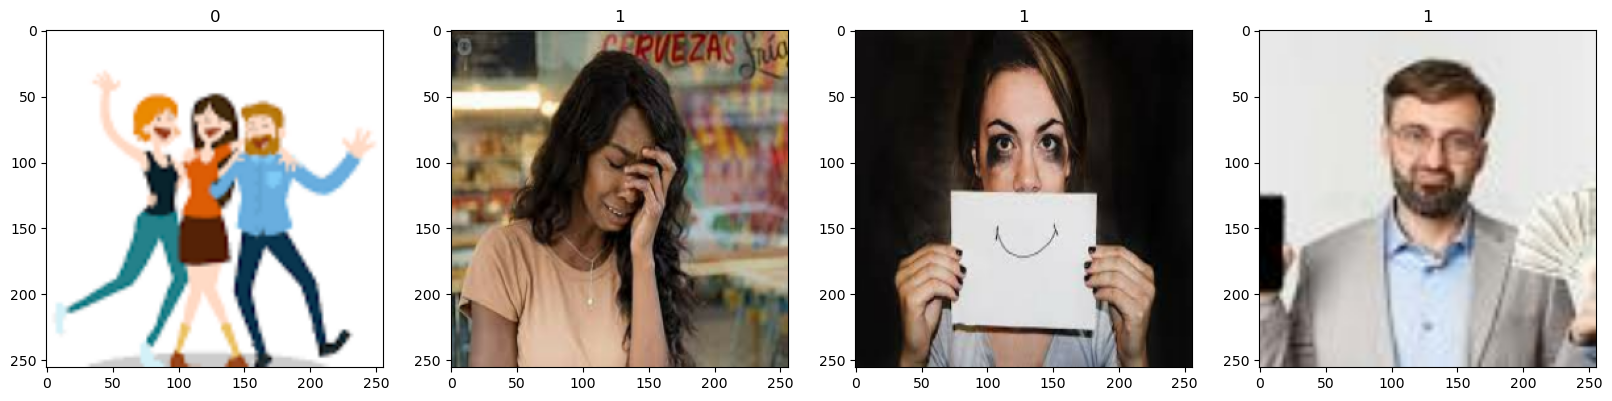

In [12]:
# Viewing first 4 images with their class
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# We can see Happy = 0 & Sad = 1

## Preprocess Data

In [13]:
# Scale the data from 0-255 -> 0-1
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))
test = test.map(lambda x, y: (x/255, y))

In [14]:
len(train) # No of batches

8

In [15]:
len(val)

2

## Build a network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [17]:
model = Sequential()

In [18]:
model.add(Input(shape=(256, 256, 3)))
model.add((Conv2D(16, (3,3), 1, activation= 'relu')))
model.add(MaxPooling2D())

model.add((Conv2D(32, (3,3), 1, activation= 'relu')))
model.add(MaxPooling2D())

model.add((Conv2D(16, (3,3), 1, activation= 'relu')))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
# Log the information for tensorboard
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20


2025-07-04 20:15:05.286958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.4488 - loss: 1.9117 - val_accuracy: 0.4754 - val_loss: 1.1129
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5475 - loss: 0.7813 - val_accuracy: 0.6721 - val_loss: 0.6145
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6617 - loss: 0.6205 - val_accuracy: 0.6557 - val_loss: 0.6441
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7332 - loss: 0.5506 - val_accuracy: 0.7377 - val_loss: 0.5809
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8402 - loss: 0.4431 - val_accuracy: 0.6066 - val_loss: 0.9898
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7338 - loss: 0.5223 - val_accuracy: 0.7869 - val_loss: 0.5471
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8128 - loss: 0.4582 - val_accuracy: 0.7541 - val_loss: 0.5930
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8860 - loss: 0.3130 - val_accuracy: 0.7869 - val_loss: 0.5803
Epo

## Evaluation

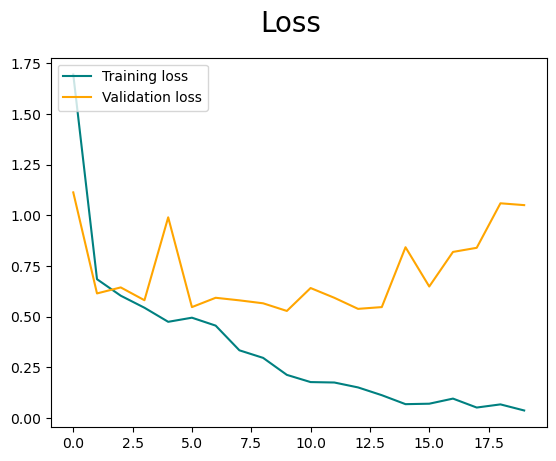

In [23]:
# Plot the performance 
# Loss vs Epochs
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation loss')
fig.suptitle('Loss', fontsize= 20)
plt.legend(loc= 'upper left')
plt.show()

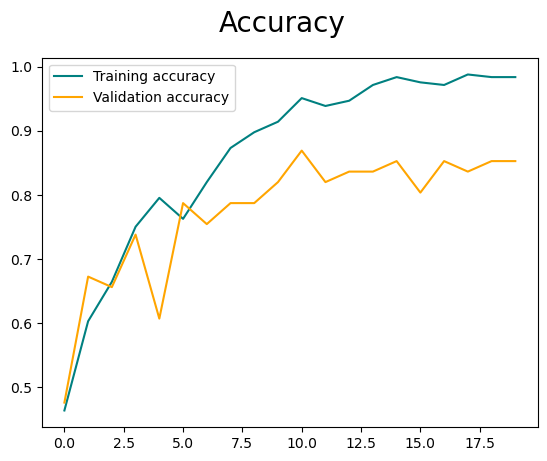

In [24]:
# Accuracy vs Epochs
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation accuracy')
fig.suptitle('Accuracy', fontsize= 20)
plt.legend(loc= 'upper left')
plt.show()

## Test

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
# Instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [27]:
# Test data
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


2025-07-04 20:15:45.861412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
print(f'Precision: {pre.result().numpy()} Recall: {re.result().numpy()} Accuracy: {acc.result().numpy()}')

Precision: 0.9523809552192688 Recall: 1.0 Accuracy: 0.9722222089767456


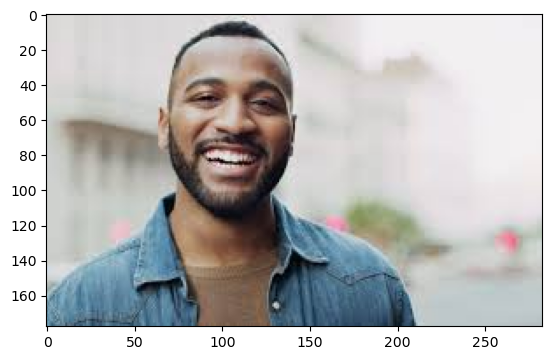

In [29]:
img = cv2.imread('happy_2.jpeg')
plt. imshow(cv2.cvtColor (img, cv2.COLOR_BGR2RGB))
plt.show()

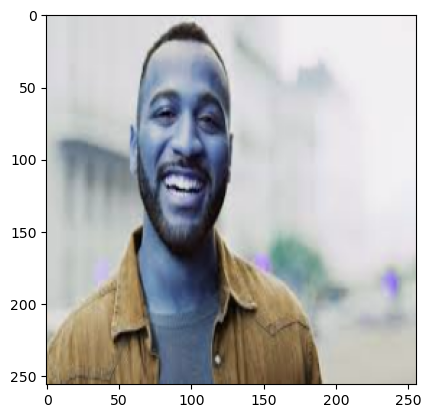

In [30]:
resize = tf.image.resize(img ,(256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
yhat_test = model.predict(np.expand_dims(resize/255, 0))
yhat_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


array([[0.04893755]], dtype=float32)

In [32]:
if yhat_test > 0.5:
    print('Image is sad')
else:
    print('Image is happy')

Image is happy


## Save the model

In [33]:
from tensorflow.keras.models import load_model

In [34]:
model.save(os.path.join('models', 'happy_sad_model.keras'))

In [35]:
new_model = load_model(os.path.join('models', 'happy_sad_model.keras'))

In [36]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([[0.04893755]], dtype=float32)

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs